In [1]:
#データとモジュールの読み込み
import numpy as np
import pandas as pd
# 機械学習のライブラリ．今回は線形回帰LinearRegressionを動かす．
# LinearRegressionはsklearnのlinear_modelモジュールの中にあるので，次のようにインポートする
from sklearn.linear_model import LinearRegression
from google.colab import drive
drive.mount('/content/drive') # google driveをマウント（＝Colabから使えるようにする）
# Google Colabの場合
d_train = pd.read_csv("/content/drive/My Drive/PBL2025/omni2_selected_2000_2024.csv") # 訓練データを読み込む
d_test = pd.read_csv("/content/drive/My Drive/PBL2025/omni2_selected_2025H1_Dst99999.csv") # テストデータを読み込む

Mounted at /content/drive


In [2]:
#指定した列だけ取り出す
xlist = [ 'Year', 'Month', 'Day_of_month','Hour[h]', 'B_mag[nT]','Bx_GSE[nT]', 'By_GSM[nT]','Bz_GSM[nT]', 'T_proton[K]', 'N_proton[cm^-3]', 'V_sw[km/s]',
         'Flow_pressure[nPa]', 'E_field[mV/m]', 'Sunspot_num', 'f10.7[sfu]', 'Lyman_alpha[W/m^2]']
         #colabの場合はReturnで改行できる
ylist = ['Dst[nT]']
x_train = d_train[xlist]
y_train = d_train[ylist]
x_test = d_test[xlist]
y_test = d_test[ylist]

In [3]:
#訓練データに新しい特徴量を追加
x_train['Bz_lag6'] = x_train['Bz_GSM[nT]'].shift(6)
x_train['Bz_diff6'] = x_train['Bz_GSM[nT]'] - x_train['Bz_GSM[nT]'].shift(6)
x_train['Bz_ma3'] = x_train['Bz_GSM[nT]'].rolling(3).mean()
x_train['Ef_lag6'] = x_train['E_field[mV/m]'].shift(6)
x_train['Ef_diff6'] = x_train['E_field[mV/m]'] - x_train['E_field[mV/m]'].shift(6)
x_train['Ef_ma3'] = x_train['E_field[mV/m]'].rolling(3).mean()
#テストデータに追加
#Add new feature
x_test['Bz_lag6'] = x_test['Bz_GSM[nT]'].shift(6)
x_test['Bz_diff6'] = x_test['Bz_GSM[nT]'] - x_test['Bz_GSM[nT]'].shift(6)
x_test['Bz_ma3'] = x_test['Bz_GSM[nT]'].rolling(3).mean()
x_test['Ef_lag6'] = x_test['E_field[mV/m]'].shift(6)
x_test['Ef_diff6'] = x_test['E_field[mV/m]'] - x_test['E_field[mV/m]'].shift(6)
x_test['Ef_ma3'] = x_test['E_field[mV/m]'].rolling(3).mean()

In [4]:
x_train = x_train.bfill() #ひとつ前のデータで補間
x_test = x_test.bfill()

In [5]:
# 分割前に必ず定義
n_train = len(x_train)
n_valid = int(0.2 * n_train)  # 検証データの数．ラベル付きデータ数n_trainの2割を検証データにする
n_train = n_train - n_valid # 訓練データ数を計算し直す．検証データ以外全てなので，全体（n_train)からn_validationを引く
x_valid = x_train[n_train:] # 現在のX_train_numの後半2割 = 前半8割以降
x_train = x_train[:n_train] # 現在のX_train_numの前半8割．再代入する（変数名を使い回す）

# 目標値も同じように分割する
y_valid = y_train[n_train:]
y_train = y_train[:n_train]

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [7]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# MLP（多層パーセプトロン）回帰
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64),  # 層とユニット数（適度に軽め）
    activation="relu",
    solver="adam",
    alpha=1e-4,                    # L2正則化
    batch_size=256,                # 大きめバッチで高速化
    learning_rate="adaptive",      # 改善しなければ学習率を自動で下げる
    learning_rate_init=1e-3,
    max_iter=500,
    early_stopping=True,           # 早期終了を有効化（自動で検証分割）
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=42,
    verbose=False
)

# 学習（y は 1次元配列にしておくと安心）
mlp.fit(x_train_scaled, np.ravel(y_train.values))

# 予測
y_pred_valid = mlp.predict(x_valid_scaled)

# MSE
mse = mean_squared_error(y_valid, y_pred_valid)
print("MSE:", mse)

# 収束情報（任意）
print("n_iter_:", getattr(mlp, "n_iter_", None))
print("best_validation_score_ (loss):", getattr(mlp, "best_validation_score_", None))



MSE: 2755.480124005739
n_iter_: 256
best_validation_score_ (loss): 0.8418411437207279


上記の計算は10分以上かかります。

より処理を軽量化して計算時間が短くなるコードです。
結果も比べてみてください。

In [10]:
# === 軽量MLP（CPU向け）最小実装：サブセットで粗調整→全量で本学習 ===
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# --- 前提：x_train, y_train, x_valid, y_valid, x_test が既にある想定 ---
# メモリ負荷と計算量を下げる
def to_float32(df):
    return df.astype(np.float32)

x_train = to_float32(x_train)
x_valid = to_float32(x_valid)
x_test  = to_float32(x_test)
y_train = np.asarray(y_train).ravel().astype(np.float32)
y_valid = np.asarray(y_valid).ravel().astype(np.float32)

# ====== 1) サブセットで軽量チューニング ======
# 時系列の“直近”を使ってサブセット（30,000行）。重ければ15000に減らしてOK
subset_n = min(len(x_train), 30000)
X_tune = x_train.iloc[-subset_n:].copy()
y_tune = y_train[-subset_n:].copy()

# 次元数に応じてPCA次元を自動決定（最大40、元の次元の半分まで）
n_features = X_tune.shape[1]
pca_k = int(min(40, max(8, n_features // 2)))  # 8〜40の範囲
print(f"PCA components: {pca_k} / {n_features}")

# CPUで重くなりにくい設定（小さめのネット＋大きめバッチ＋早期終了）
def make_mlp():
    return MLPRegressor(
        hidden_layer_sizes=(64, 32),   # さらに軽くしたい時は (32,16) に
        activation="relu",
        solver="adam",
        alpha=1e-3,                    # L2正則化やや強めで安定
        batch_size=1024,               # 大きめバッチでCPUでも速め
        learning_rate="adaptive",
        learning_rate_init=8e-4,       # 少し低めで安定
        max_iter=140,                  # 短め＋早期終了
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=12,
        random_state=42,
        verbose=False
    )

# パイプライン：欠損補完→標準化→PCA→MLP（木系じゃないのでスケーリング重要）
pipe_tune = Pipeline([
    ("imp",  SimpleImputer(strategy="median")),
    ("sc",   StandardScaler(with_mean=True, with_std=True)),
    ("pca",  PCA(n_components=pca_k, svd_solver="auto", random_state=42)),
    ("mlp",  make_mlp()),
])

pipe_tune.fit(X_tune, y_tune)
y_pred_valid_tune = pipe_tune.predict(x_valid)
mse_tune = mean_squared_error(y_valid, y_pred_valid_tune)
print("[TUNE] valid MSE:", mse_tune)

# ====== 2) 全量データで本学習（同構成） ======
pipe_full = Pipeline([
    ("imp",  SimpleImputer(strategy="median")),
    ("sc",   StandardScaler(with_mean=True, with_std=True)),
    ("pca",  PCA(n_components=pca_k, svd_solver="auto", random_state=42)),
    ("mlp",  make_mlp()),
])

pipe_full.fit(x_train, y_train)
y_pred_valid = pipe_full.predict(x_valid)
mse_valid = mean_squared_error(y_valid, y_pred_valid)
print("[FULL] valid MSE:", mse_valid)

# ====== 3) テスト評価（必要なら） ======
y_pred_test = pipe_full.predict(x_test)
# ここで y_test があるなら MSE を計算:
# mse_test = mean_squared_error(y_test, y_pred_test); print("[FULL] test MSE:", mse_test)


PCA components: 11 / 22
[TUNE] valid MSE: 3674.03076171875
[FULL] valid MSE: 346.52520751953125


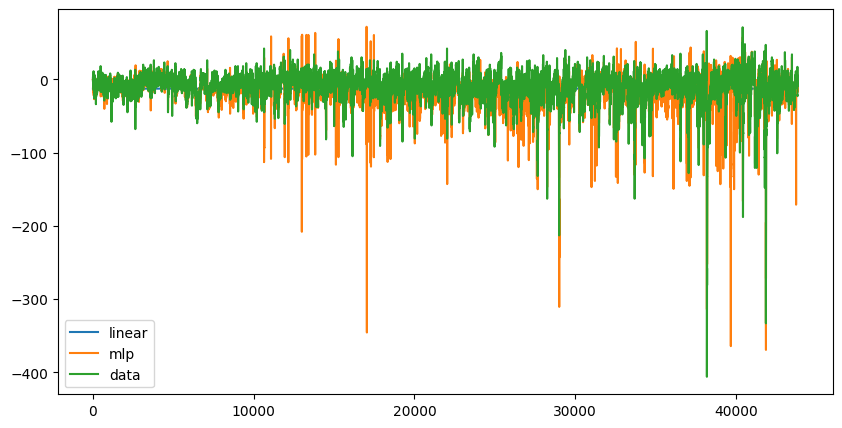

In [14]:
#モジュールの読み込み
from sklearn.linear_model import LinearRegression

# 通常の線形モデルの作成と予測
lr = LinearRegression()# LinearRegressionのインスタンスの作成
lr.fit(x_train, y_train)# 上で作ったオブジェクトの学習
y_pred_valid_lr = lr.predict(x_valid)#　検証データに対する予測

import matplotlib.pyplot as plt
xplot = np.arange(n_valid) # 0,1,2...n_valid-1のような配列になる
plt.figure(figsize=(10,5)) #figsize => (x,y)の図のサイズ
plt.plot(xplot,y_pred_valid_lr,label="linear") #label; 凡例の文字
plt.plot(xplot,y_pred_valid,label="mlp") #label; 凡例の文字
plt.plot(xplot,y_valid,label="data")
plt.legend() #凡例を表示
plt.show()

In [15]:
#テストデータの予測と提出
y_pred_test = mlp.predict(x_test_scaled)
np.savetxt('/content/drive/My Drive/PBL2025/y_pred_mlp.csv', y_pred_test,delimiter=',')